In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from numpy import exp
from scipy import ndimage
from VMOSfunc import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import leastsq
from cosmocalc import dist
from pprint import pprint


In [2]:
def flux_data_err(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    hdu = fits.open('%s/Flux Maps/%s/19_arcsec_subcube_par_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr,OIII_br,Hb1_blr_br,Hb2_blr_br) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/19_arcsec_subcube_par_err_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr_err,OIII_br_err,Hb1_blr_br_err,Hb2_blr_br_err) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/%s/%s_19_arcsec_empirical_factor_subcube.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (emp_Hb1,emp_Hb2) = (central_tab.field('emp_fact_Hb1')[0],central_tab.field('emp_fact_Hb2')[0])
    hdu.close()
    
    (amp_OIII_nr,amp_OIII_br,amp_Hb1_blr_br,amp_Hb2_blr_br) = (np.max(OIII_nr),np.max(OIII_br),np.max(Hb1_blr_br),np.max(Hb2_blr_br))
    if amp_Hb1_blr_br > amp_Hb2_blr_br:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb1_blr_br,amp_Hb1_blr_br,Hb1_blr_br_err,emp_Hb1)
    else:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb2_blr_br,amp_Hb2_blr_br,Hb2_blr_br_err,emp_Hb2)
    print (emp_Hb_blr)
    (blr_err_final,wing_err_final,core_err_final) = (emp_Hb_blr*Hb_blr_err,emp_Hb_blr*OIII_br_err,OIII_nr_err)
    return Hb_blr_br,OIII_br,OIII_nr,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,blr_err_final,wing_err_final,core_err_final
    

In [3]:
def remove_bad_pixel(data,err):
    data[data == 0.01] = 0
    err[err < 10**(-7)] =10**(10)  
    return data,err

In [4]:
def ellip_moffat2D(p,xy,data,error):
    xy=(x,y)
    [amp, x0, y0, A, B, C, alpha] = p 
    g = amp*((1.0+A*(x-x0)**2+B*(y-y0)**2+C*(x-x0)*(y-y0))**(-alpha))
    h = (data - g)/error
    return h.ravel()

def ellip_moffat2D_fixkin(p,xy,data,error,fixed_param):
    [A,B,C,alpha] = fixed_param
    xy=(x,y)
    [amp, x0, y0] = p    
    g = amp*((1.0+(A*((x-x0)**2))+(B*((y-y0)**2))+(C*(x-x0)*(y-y0)))**(-alpha))
    h = (data - g)/error
    return h.ravel()

In [9]:
def elliptical_moffat_fit(x_BH,y_BH,data,error,box_size,amp,x0,y0,muse_sampling_size,fix_par,MC_loops=100):
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    
    if fix_par is None:
        #p= [amp,x0,y0,0.1,0.1,-0.00008,3
        p= [amp,x0,y0,1.11521262e-01,1.72774616e-01,3.95458884e-04,3.79696142e+00]
        popt,pcov = leastsq(ellip_moffat2D,x0=p,args=(xy,data,error),maxfev = 10000000)
        [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out]= popt
        theta_out = 0.5*np.arctan(C_out/(A_out - B_out))
        a_out = np.sqrt(2/(A_out + B_out + np.sqrt(C_out**2 +(A_out - B_out)**2)))
        b_out = np.sqrt(2/(A_out + B_out - np.sqrt(C_out**2 +(A_out - B_out)**2)))
        [fwhm1_out,fwhm2_out] = [2*a_out*np.sqrt(2**(1/alpha_out)-1),2*b_out*np.sqrt(2**(1/alpha_out)-1)]
        e_out = np.sqrt(1-((fwhm1_out**2)/(fwhm2_out**2)))
        par = [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out,a_out,b_out,theta_out,fwhm1_out,fwhm2_out,e_out]
        mod_rav = data.ravel() - ellip_moffat2D(popt,xy,data,error)*error.ravel()
    else:
        p= [amp,x0,y0]
        popt,pcov = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,data,error,fix_par),maxfev = 10000000)
        [amp_out,x0_out,y0_out]= popt
        par = popt
        mod_rav = data.ravel() - ellip_moffat2D_fixkin(popt,xy,data,error,fix_par)*error.ravel()
    model = mod_rav.reshape(box_size,box_size)
    radius = 2
    [x1,y1] = ndimage.measurements.maximum_position(data) # Define the PSF center
    small_data = data[(x-x1)**2 + (y-y1)**2 <= radius**2]
    small_model = model[(x-x1)**2 + (y-y1)**2 <= radius**2]
    ratio_flux = np.sum(small_data)/np.sum(small_model)
    
    full_par = np.append(par,ratio_flux)
    residual = data-model
    res = (residual/error)
    
    ratio_MC = np.zeros((1,MC_loops))
    parameters_MC = np.zeros((len(par),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(data,error) 
        if fix_par is None:
            p= [amp,x0,y0,0.1,0.1,-0.00008,3]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D,x0=p,args=(xy,iteration_data,error),maxfev = 10000000)
            [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC]= popt_MC
            theta_MC = 0.5*np.arctan(C_MC/(A_MC - B_MC))
            a_MC = np.sqrt(2/(A_MC + B_MC + np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            b_MC = np.sqrt(2/(A_MC + B_MC - np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            [fwhm1_MC,fwhm2_MC] = [2*a_MC*np.sqrt(2**(1/alpha_MC)-1),2*b_MC*np.sqrt(2**(1/alpha_MC)-1)]
            e_MC = np.sqrt(1-((fwhm1_MC**2)/(fwhm2_MC**2)))
            par_MC = [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC,a_MC,b_MC,theta_MC,fwhm1_MC,fwhm2_MC,e_MC]   
            mod_rav_MC = iteration_data.ravel() - ellip_moffat2D(popt_MC,xy,iteration_data,error)*error.ravel() 
            parameters_MC[:,l] = par_MC
        else:
            p= [amp,x0,y0]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,iteration_data,error,fix_par),maxfev = 10000000)
            [amp_MC,x0_out,y0_out]= popt_MC
            mod_rav_MC = iteration_data.ravel() - ellip_moffat2D_fixkin(popt_MC,xy,iteration_data,error,fix_par)*error.ravel()
            parameters_MC[:,l] = popt_MC   
        model_MC = mod_rav_MC.reshape(box_size,box_size)
        radius = 2
        [x1,y1] = ndimage.measurements.maximum_position(iteration_data) # Define the PSF center
        small_data_MC = iteration_data[(x-x1)**2 + (y-y1)**2 <= radius**2]
        small_model_MC = model_MC[(x-x1)**2 + (y-y1)**2 <= radius**2]
        ratio_flux_MC = np.sum(small_data_MC)/np.sum(small_model_MC)
        ratio_MC[:,l] = ratio_flux_MC
    ratio_err = np.nanstd(ratio_MC,1)
    par_err = np.nanstd(parameters_MC,1) 
    parameters_err = np.append(par_err,ratio_err)

    return full_par,parameters_err,model,res

In [10]:
def moffat_table(full_data,full_error,D_A,D_L,muse_sampling_size,obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    final_data = np.append(full_data,[D_A,D_L,muse_sampling_size])
    final_error = np.append(full_error,[0,0,0])
    column_names={'amp_Hb_blr':0,'x0_Hb_Blr':1,'y0_Hb_Blr':2,'A':3,'B':4,'C':5,'alpha':6,'a':7,'b':8,'theta':9,'fwhm1':10,'fwhm2':11,'e':12,'r_BLR':13,'amp_OIII_br':14,'x0_OIII_br':15,'y0_OIII_br':16,'r_wing':17,'amp_OIII_nr':18,'x0_OIII_nr':19,'y0_OIII_nr':20,'r_core':21,'D_A':22,'D_L':23,'sampling_size':24}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[final_data[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[final_error[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/19_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def source_moffat_table(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/19_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_19_arcsec_moffat_table.fits'%(destination_path_cube,obj,obj),overwrite=True)


def maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(Hb_blr_br_data,name='Hb_blr_br_data'))
    hdus.append(fits.ImageHDU(OIII_br_data,name='OIII_br_data'))
    hdus.append(fits.ImageHDU(OIII_nr_data,name='OIII_nr_data'))
    hdus.append(fits.ImageHDU(Hb_model,name='Hb_blr_br_model'))
    hdus.append(fits.ImageHDU(OIII_br_model,name='OIII_br_model'))   
    hdus.append(fits.ImageHDU(OIII_nr_model,name='OIII_nr_model'))
    hdus.append(fits.ImageHDU(Hb_res,name='Hb_blr_br_res'))
    hdus.append(fits.ImageHDU(OIII_br_res,name='OIII_br_res'))
    hdus.append(fits.ImageHDU(OIII_nr_res,name='OIII_nr_res'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/%s/19_arcsec_maps_%s.fits'%(destination_path_cube,obj,obj),overwrite='True')

def fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    f_blr_data = np.sum(Hb_blr_br_data)
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    f_blr_err = np.sqrt(np.sum(Hb_blr_br_err**2))
    f_wing_err = np.sqrt(np.sum(OIII_br_err**2))
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    tab_err = [f_blr_err,f_wing_err,0,0]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[tab_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_19_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_19_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_19_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def emp_table(obj,emp_blr,emp_wing,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    popt = [emp_blr,emp_wing]
    column_names={'emp_fact_blr':0,'emp_fact_wing':1}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_19_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

def emp_fact_table(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_19_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_19_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

In [11]:
def algorithm_script(obj,z,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):  
    print ('%s'%(obj))
    (Hb_blr_br_dat,OIII_br_dat,OIII_nr_dat,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_error,OIII_br_error,OIII_nr_error) = flux_data_err(obj)
    (Hb_blr_br_data,Hb_blr_br_err) = remove_bad_pixel(Hb_blr_br_dat,Hb_blr_br_error)
    (OIII_br_data,OIII_br_err) = remove_bad_pixel(OIII_br_dat,OIII_br_error)
    (OIII_nr_data,OIII_nr_err) = remove_bad_pixel(OIII_nr_dat,OIII_nr_error)  
    box_size = np.shape(Hb_blr_br_data)[0]
    (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y) = brightest_pixel_flux_map(Hb_blr_br_data,OIII_br_data,OIII_nr_data) 
    (x_BH,y_BH) = (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y)
    print (brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y)
    
    if box_size ==45:
        muse_sampling_size = 0.66
    else:
        muse_sampling_size = 0.66
  
    print (muse_sampling_size)
    (Hb_par,Hb_error,Hb_model,Hb_res) = elliptical_moffat_fit(x_BH,y_BH,Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,muse_sampling_size,None,100)
    print (Hb_par,Hb_error)
    #print (red_chi_sq_Hb)
    fixed_param = [Hb_par[3],Hb_par[4],Hb_par[5],Hb_par[6]]
    (OIII_br_par,OIII_br_error,OIII_br_model,OIII_br_res) = elliptical_moffat_fit(x_BH,y_BH,OIII_br_data,OIII_br_err,box_size,amp_OIII_br,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,muse_sampling_size,fixed_param,100)   
    print (OIII_br_par,OIII_br_error)
    (OIII_nr_par,OIII_nr_error,OIII_nr_model,OIII_nr_res) = elliptical_moffat_fit(x_BH,y_BH,OIII_nr_data,OIII_nr_err,box_size,amp_OIII_nr,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y,muse_sampling_size,fixed_param,100)   
    print (OIII_nr_par,OIII_nr_error)

    (D_A,D_L) = dist(z, H0=70, WM=.286)
    (full_data,full_error) = (np.append(Hb_par,[OIII_br_par,OIII_nr_par]),np.append(Hb_error,[OIII_br_error,OIII_nr_error]))
    moffat_table(full_data,full_error,D_A,D_L,muse_sampling_size,obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS")
    maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj)
    fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err)
    source_moffat_table(obj)
        
    plt.imshow(Hb_blr_br_data,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(Hb_model,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(OIII_br_data,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_br_model,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_nr_data,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    plt.imshow(OIII_nr_model,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    

2.6828783
HE1310-1051
2.6828783
14 14
0.66
[ 1.37990983e+00  1.36208547e+01  1.36740124e+01  1.11521300e-01
  1.72774667e-01  3.95422188e-04  3.79695998e+00  2.40579804e+00
  2.99448630e+00 -3.22771399e-03  2.15330617e+00  2.68021077e+00
  5.95427202e-01  1.00667406e+00] [0.00437209 0.00278921 0.00185156 0.001922   0.00296155 0.000581
 0.04419356 0.0205766  0.02577679 0.00469851 0.00565479 0.00700895
 0.00204418 0.00067967]
[ 2.69377825 13.6379676  13.65161323  1.01248565] [0.00907461 0.00579847 0.00418532 0.00312523]
[10.03700748 13.60469665 13.69615993  0.98037296] [0.0064284  0.00088398 0.00076287 0.0005366 ]


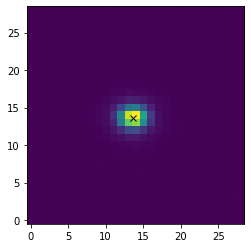

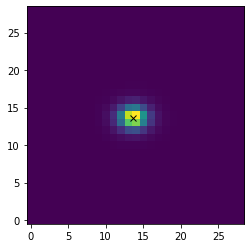

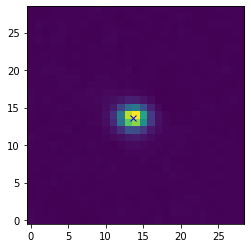

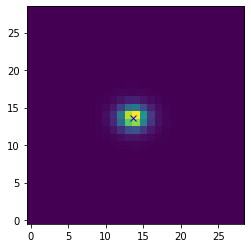

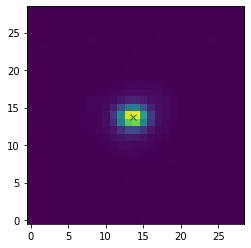

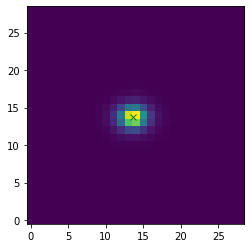

2.3177226
HE1338-1423
2.3177226
14 14
0.66
[ 4.90631426 13.7483605  13.94687862  0.2698351   0.49523027  0.03351426
  2.93481525  1.41923335  1.92952386 -0.0738048   1.46505398  1.99181947
  0.67748615  1.01737033] [0.06655853 0.00621358 0.00409875 0.01331773 0.02336106 0.00449527
 0.08218292 0.03341099 0.04789899 0.00919735 0.01330986 0.01945817
 0.00412385 0.002466  ]
[12.28799496 13.6597225  13.66635295  0.74198506] [0.02958391 0.00228969 0.00240823 0.00174087]
[10.24442901 13.66395388 13.92969961  1.16650038] [0.0166064  0.00188838 0.00099507 0.00153143]


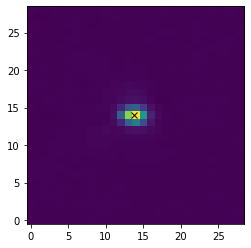

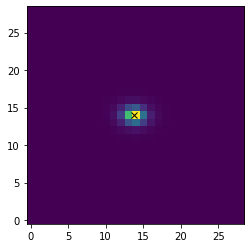

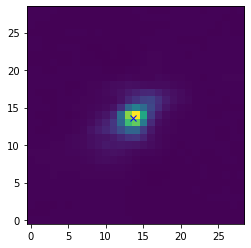

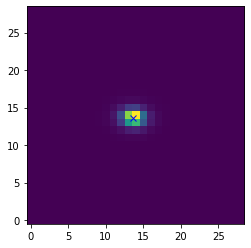

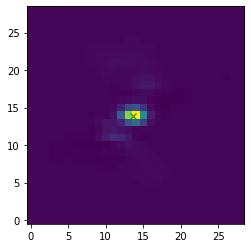

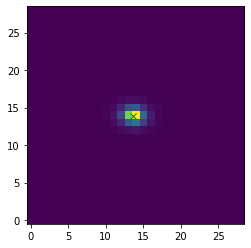

In [12]:
z = {"HE1310-1051":0.03427,"HE1338-1423":0.04179}

objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])